# Simple ARIMA model for non-seasonal time-serie forecast

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data
Let's start by loading the time series of the challenge

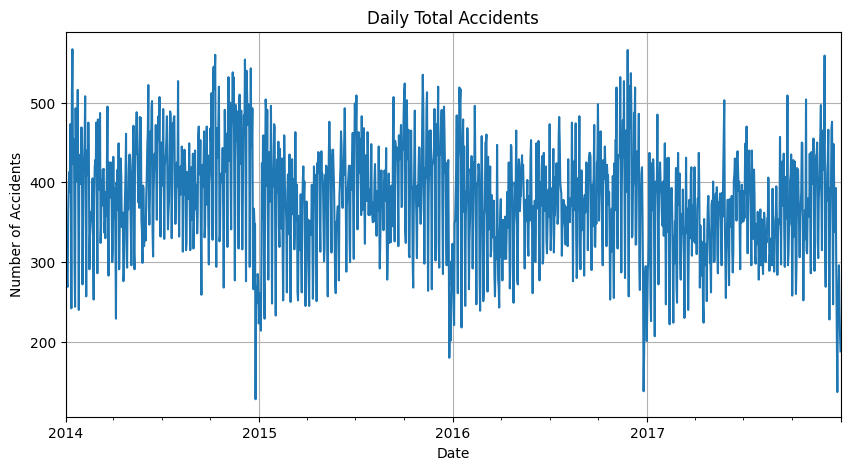

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV (replace with actual filename if needed)
df = pd.read_csv('accident_UK (4).csv', parse_dates=['Date'], dayfirst=True)

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Extract the time series
y = df['Total_Accident']

# Plot the time series
df.plot(figsize=(10, 5), legend=False)
plt.title('Daily Total Accidents')
plt.ylabel('Number of Accidents')
plt.xlabel('Date')
plt.grid(True)
plt.show()

This abstract time serie does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regresive Moving Average (ARIMA) models


## 2. Build ARIMA model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time serie (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the Moving-Average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure stationarity

ARIMA models applies to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [35]:
from statsmodels.tsa.stattools import adfuller
print('p-value: ', adfuller(y)[1])

p-value:  3.4770429612346953e-06


The p-value should be  less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat process on the differentiated serie if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationnary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

In [36]:
# 0 diff
print('p-value: ', adfuller(y)[1])

p-value:  3.4770429612346953e-06


In [37]:
# First diff
print('p-value: ', adfuller(y.diff(1).fillna(0))[1])

p-value:  1.9493591580863763e-22


In [38]:
# Second order diff
print('p-value: ', adfuller(y.diff(1).diff(1).fillna(0))[1])

p-value:  5.830783488809784e-29


We have a close-call here between one and two diff orders. Differentiating too much a time series may also reduce performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

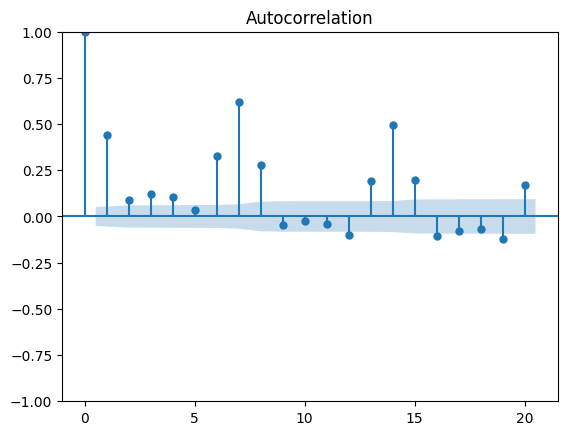

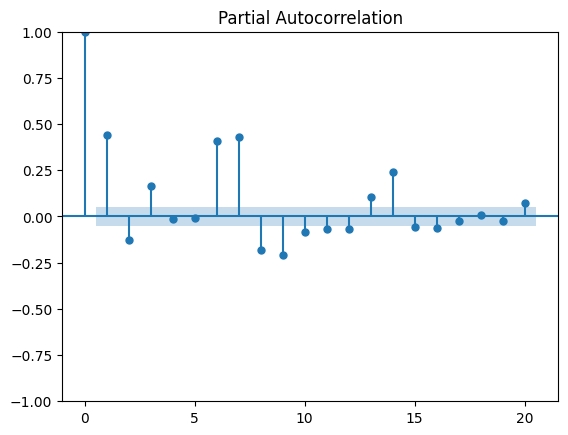

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y, lags=20)
plot_pacf(y, lags=20)
plt.show()

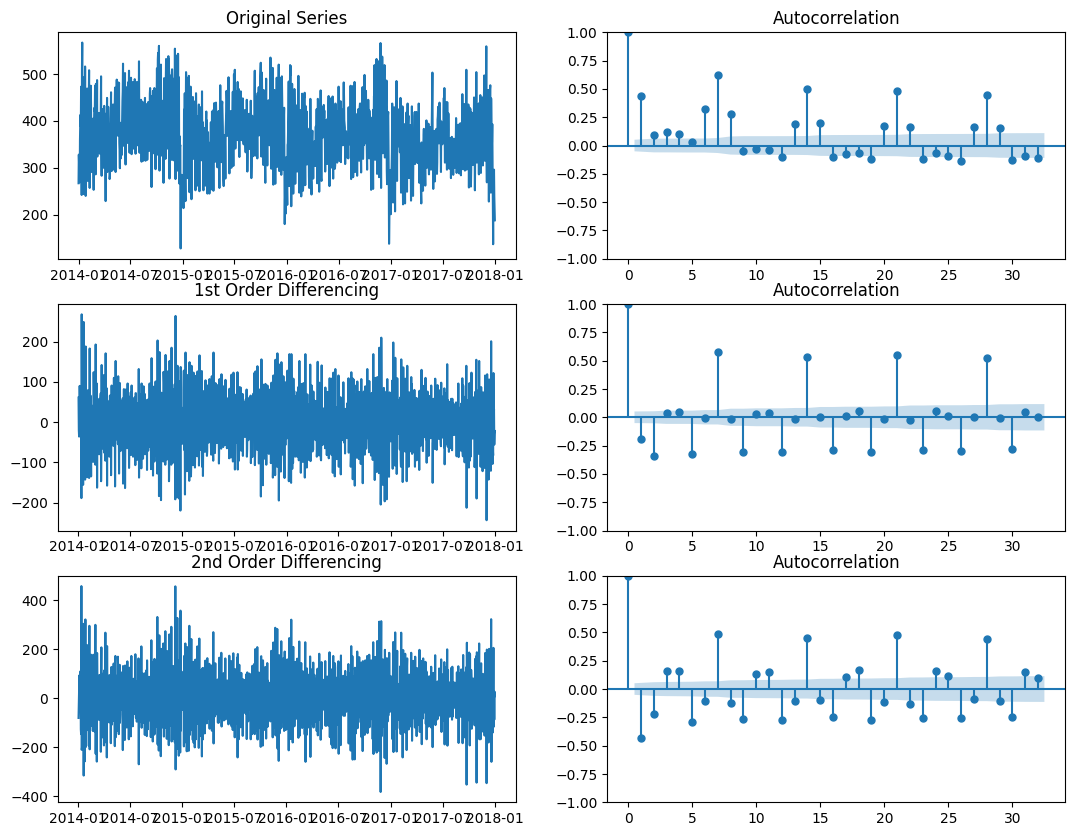

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(3, 2, figsize=(13,10))
axes[0, 0].plot(y); axes[0, 0].set_title('Original Series')
plot_acf(y, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (temptatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [7]:
y_diff = y.diff().dropna()

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary (I refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

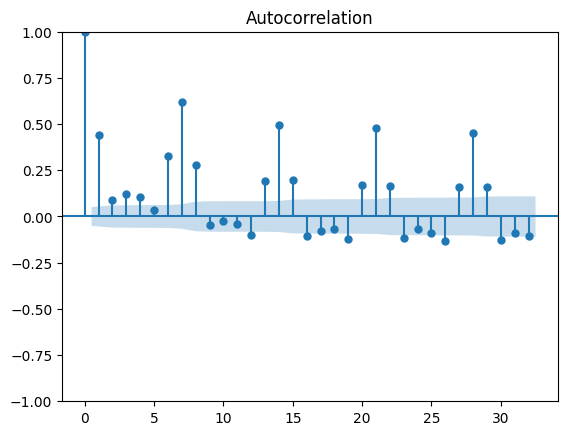

In [41]:
plot_acf(y);

We could choose q = 4, but it's more conservatively to try with `q=2` to start with.

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

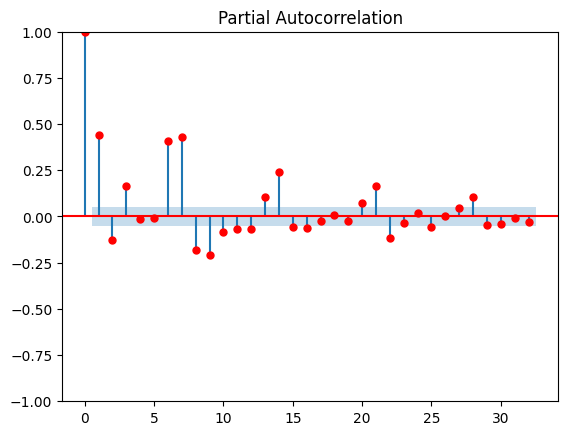

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(y, c='r');

We could choose `p = 3` as the first 3 lag terms seems above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d` and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the the model
- print the model (`.summary`)

In [43]:
from statsmodels.tsa.arima.model import ARIMA 

# 1. initialize the model
arima = ARIMA(y, order=(1, 0, 1))

# 2. fit the models
arima = arima.fit()

arima.summary()

c:\Users\I59384\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\I59384\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\I59384\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Total_Accident   No. Observations:                 1461
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8056.426
Date:              mer., 04 juin 2025   AIC                          16120.853
Time:                        14:35:10   BIC                          16142.000
Sample:                    01-01-2014   HQIC                         16128.741
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        378.4947      2.528    149.722      0.000     373.540     383.449
ar.L1          0.1244      0.047      2.637      0.008       0.032       0.217
ma.L1          0.4020      0.047      8.481      0.000       0.309       0.495
sigma2      3609.5688    137.866     26.182      0.000    3339.356    3879.782
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.93   Prob(JB):                         0.73
Heteroskedasticity (H):               0.84   Skew:                             0.00
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

☝️ If your p-values are too high, try remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate overall performance of your fit by minimizing the [`AIC - akaike information criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remains low) and maintain a quasi similar AIC score than other models

## 3. Evaluate model performance

👉 Visualize your model predictions with `.plot_predict()`

- Look closely at the method default params, especially `dynamic`. 
- Do you think your model would have such good performance in reality?

In [11]:
# Actual vs Fitted
arima.plot_predict(dynamic=False);

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

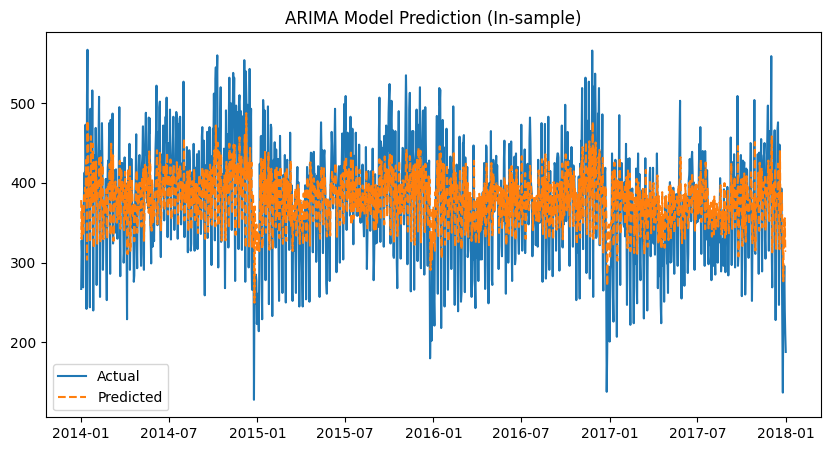

In [44]:
import matplotlib.pyplot as plt

# Predict in-sample values
pred = arima.predict(start=0, end=len(y)-1)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y, label='Actual')
plt.plot(pred, label='Predicted', linestyle='--')
plt.legend()
plt.title('ARIMA Model Prediction (In-sample)')
plt.show()

☝️ `dynamic=False` actually makes use of all available values `y` in order to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prection of the _last 15 values_ in a situation where the model only have _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ it's previouly predicted value for 86
- etc...iteratively until 100

c:\Users\I59384\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\I59384\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\I59384\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


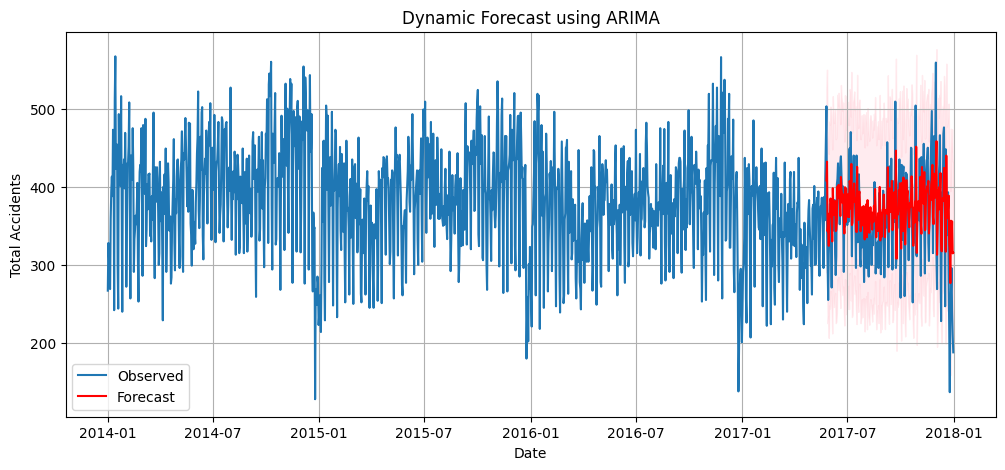

In [49]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


# Train ARIMA on full dataset
model = ARIMA(y, order=(1, 0, 1))
arima = model.fit()

# Define dynamic prediction start and end dates
start_date = y.index[int(len(y)*0.85)]  # around 60% of the dataset
end_date = y.index[int(len(y)*1)-1]    # around 70%

# Get dynamic prediction
prediction = arima.get_prediction(start=start_date, end=end_date, dynamic=False)
pred_mean = prediction.predicted_mean
conf_int = prediction.conf_int()

# Plot actual data
plt.figure(figsize=(12, 5))
plt.plot(y, label='Observed')

# Plot predicted values
plt.plot(pred_mean.index, pred_mean, label='Forecast', color='red')

# Confidence intervals
plt.fill_between(pred_mean.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)

plt.legend()
plt.title('Dynamic Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Total Accidents')
plt.grid(True)
plt.show()

☝️ That's still not a _true_ forecast!! Why??

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` serie during the fitting phase!
</details>

### 3.1 Out-of-sample forecasts (real "future")

👉 Create a train-test-split keep the last 15 datapoints only for the test set, and train your ARIMA on the train set only.

In [16]:
y_train = y[:85]
y_test = y[85:]
arima = ARIMA(y_train, order=(1, 1, 1)).fit()

👉 We are "now" in step 85 and have never seen the future:
- Use `.forecast()` method on your fitted model to "forecast" the 15 next datapoints (i.e beyond the end of your train dataset) 
- Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

In [17]:
(forecast, stderr, conf_int) = arima.forecast(15, alpha=0.05)

c:\Users\I59384\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ValueError: too many values to unpack (expected 3)

In [20]:
forecast = pd.Series(forecast, name='forecast')
stderr = pd.Series(stderr)
conf_int = pd.DataFrame(conf_int, columns=['low', 'high'])

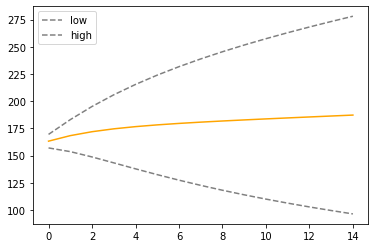

In [21]:
plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='grey', ls='--')
plt.plot(conf_int['high'], label='high', c='grey', ls='--')
plt.legend()

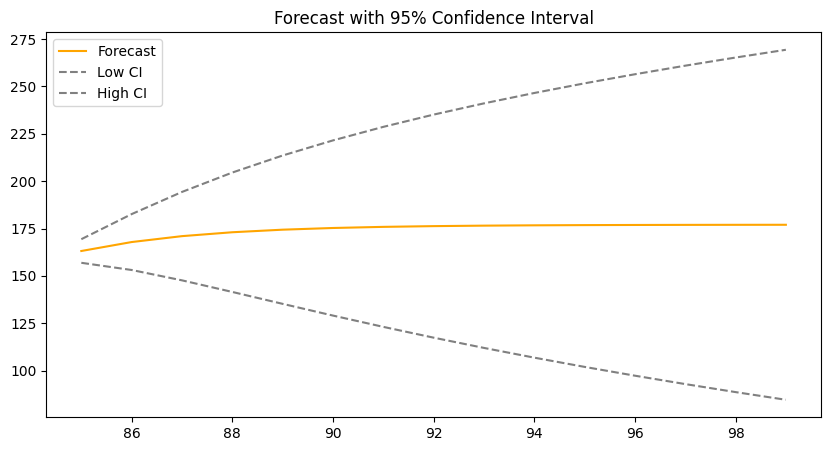

In [22]:
# Step 1: Forecast with confidence intervals
forecast_obj = arima.get_forecast(steps=15)
forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int(alpha=0.05)

# Step 2: Convert to pandas objects for plotting (if not already)
forecast = pd.Series(forecast, name='forecast')
conf_int.columns = ['low', 'high']  # Rename columns

# Step 3: Plot
plt.figure(figsize=(10, 5))
plt.plot(forecast, color='orange', label='Forecast')
plt.plot(conf_int['low'], label='Low CI', color='grey', linestyle='--')
plt.plot(conf_int['high'], label='High CI', color='grey', linestyle='--')
plt.legend()
plt.title('Forecast with 95% Confidence Interval')
plt.show()

👉 Try to also plot your previous 85 `y` real datapoints to better grasp model performance relative to the past

In [19]:
forecast.index = y_test.index
conf_int.index = y_test.index

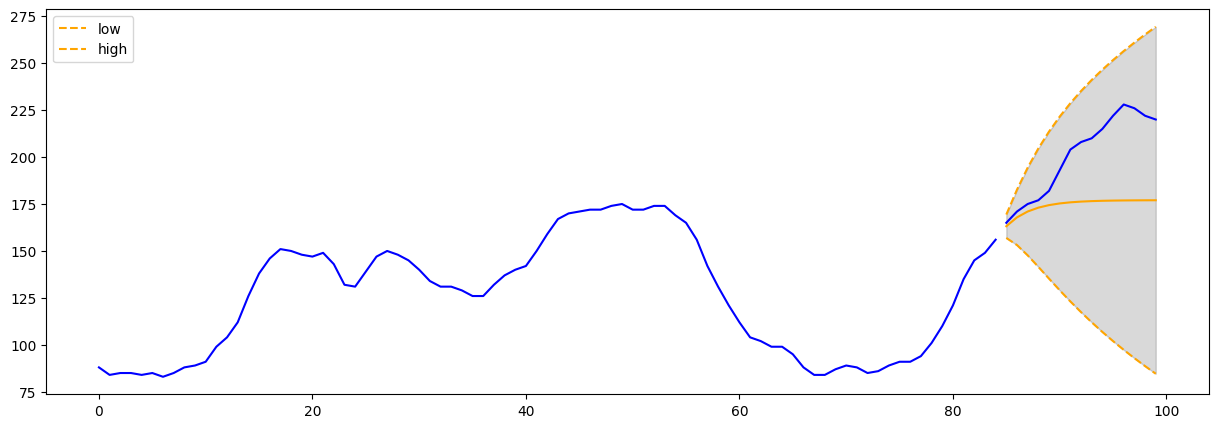

In [21]:
plt.figure(figsize=(15,5))
plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='orange', ls='--')
plt.plot(conf_int['high'], label='high', c='orange', ls='--')
plt.plot(y_train, c='blue')
plt.plot(y_test, c='blue')
plt.legend()
plt.fill_between(y_test.index, conf_int['low'], conf_int['high'], color='k', alpha=.15)

### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals if you really want)

Note: residuals are constructed by 'seing' all data as in `plot_predict(dynamic=False)`

Also try to plot a histogram or kde fit of the residuals to see if they are approximately normally distributed.

<Axes: title={'center': 'Residuals'}, xlabel='Date'>

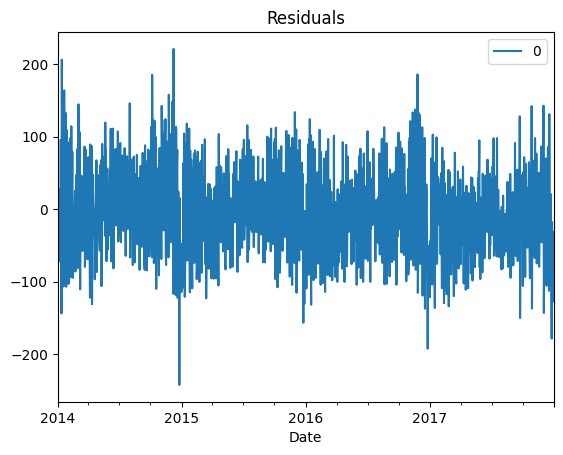

In [52]:
residuals = pd.DataFrame(arima.resid)
residuals.plot(title="Residuals")

<Axes: title={'center': 'Residual density'}, ylabel='Density'>

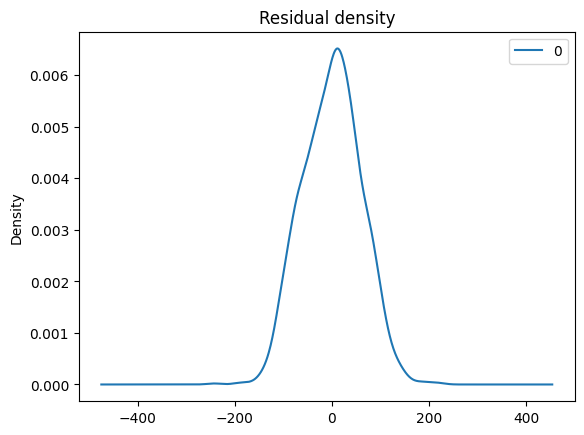

In [53]:
residuals.plot(kind='kde', title='Residual density')

## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [54]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

👉 Play with you ARIMA hyper-parameters and see the impact on your forecast performance

In [55]:
forecast_accuracy(forecast, y_test)

TypeError: unsupported operand type(s) for -: 'PredictionResultsWrapper' and 'int'

## 4 Grid Search

Try to run your own gridsearch for (p,d,q) using `pmdarima`. Use at least
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [58]:

import pmdarima as pm

model = pm.auto_arima(y_train, 
                      start_p=0, max_p=2,
                      start_q=0, max_q=2, 
                      d=None,           # let model determine 'd'
                      test='adf',       # using adftest to find optimal 'd'
                      trace=True, error_action='ignore',  suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=397.324, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=397.517, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=394.597, Time=0.16 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=394.958, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=390.953, Time=0.27 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=1.83 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=392.911, Time=0.41 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 2.860 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   75
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -192.477
Date:              mer., 04 juin 2025   AIC                            390.953
Time:                        15:20:54   BIC                            397.825
Sample:                           

## (Optional) Cross-validate performance of your model?

In practice, Results and GridSearch should always be cross validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create continguous K-folds so as to truely evaluate the performance of your model and find the best hyper-params after cross validation

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>

In [26]:
###########################################################
#   Arima - Cross-Validation using TimeSeriesSplit + Grid Search
##########################################################

In [59]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import itertools

range_p = [0,1,2]
range_d = [1,2]
range_q = [0,1,2]
grid = itertools.product(range_p, range_d, range_q)
orders = []
r2s = []
aics = []
fold_idxs = []
for (p,d,q) in grid:
    order = (p,d,q)
    folds = TimeSeriesSplit(n_splits=3)
    for fold_idx, (train_idx, test_idx) in enumerate(folds.split(y)):
        fold_idxs.append(fold_idx)
        y_train = y[train_idx]
        y_test = y[test_idx]
        model = ARIMA(y_train, order=order).fit()
        # y_pred = model.forecast(len(y_test))[0] for unknown reason this crash
        # r2s.append(r2_score(y_pred, y_true))
        orders.append(order)
        aics.append(model.aic)
        
        
df = pd.DataFrame(list(zip(fold_idxs, orders, aics)),#, r2s)), 
                   columns =['Fold', '(p,d,q)', 'AIC'])#, 'R2'])

C:\Users\I59384\AppData\Local\Temp\ipykernel_70856\2881398407.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = y[train_idx]
C:\Users\I59384\AppData\Local\Temp\ipykernel_70856\2881398407.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = y[test_idx]
c:\Users\I59384\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\I59384\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

In [60]:
df.sort_values('AIC').groupby('(p,d,q)').mean()['AIC'].sort_values()

(p,d,q)
(2, 1, 2)    8083.684263
(1, 1, 2)    8086.999907
(2, 1, 1)    8087.425415
(0, 1, 2)    8087.651398
(2, 2, 2)    8089.459714
(1, 1, 1)    8125.451275
(0, 1, 1)    8190.958951
(0, 2, 2)    8192.746078
(1, 2, 2)    8208.007207
(2, 2, 1)    8208.347169
(2, 1, 0)    8209.014988
(1, 2, 1)    8343.490529
(1, 1, 0)    8345.072321
(0, 2, 1)    8368.327370
(0, 1, 0)    8370.261932
(2, 2, 0)    8600.428013
(1, 2, 0)    8846.683857
(0, 2, 0)    8991.803377
Name: AIC, dtype: float64

☝️ Our initial choice of model (1,1,1) is not so bad!
Notice that the dataset (100 datapoints) is in reality way to small to cross-val anything!

c:\Users\I59384\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\I59384\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\I59384\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


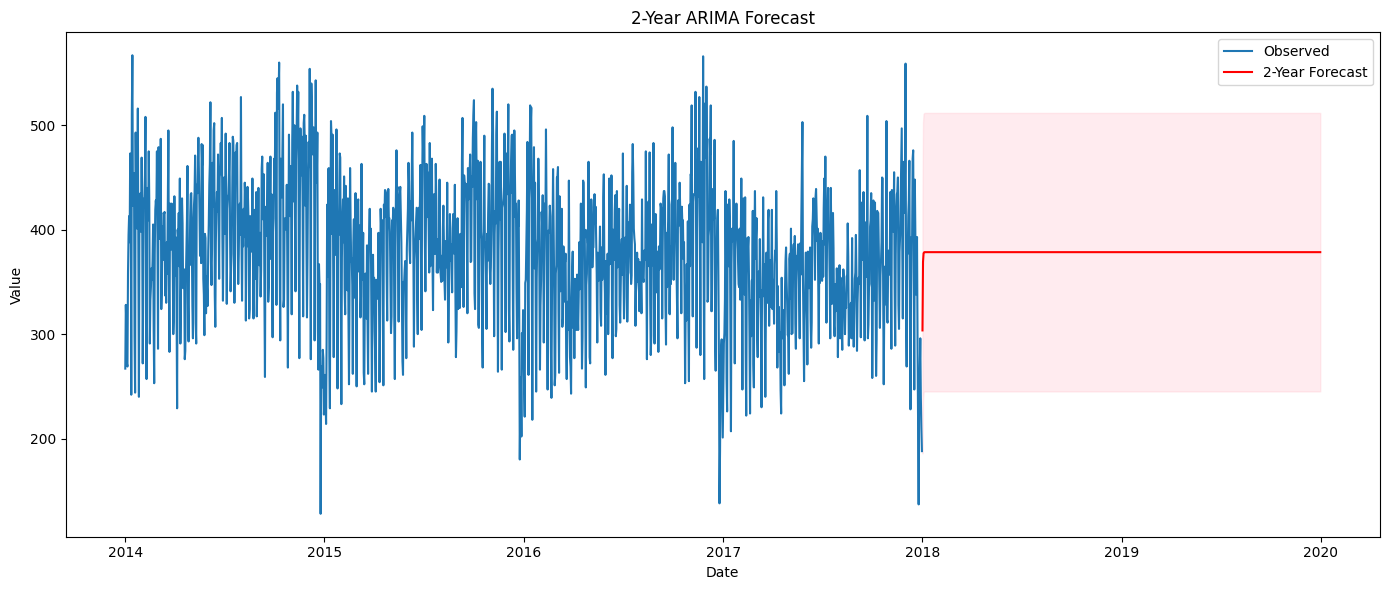

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


# Fit ARIMA on training data
model = ARIMA(y, order=(1, 0, 1)) 
arima = model.fit()

# Forecast the next 730 days (2 years)
forecast_steps = 730
forecast = arima.get_forecast(steps=forecast_steps)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Create forecast index (daily)
forecast_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
pred_mean.index = forecast_index
conf_int.index = forecast_index

# Plot everything
plt.figure(figsize=(14, 6))
plt.plot(y, label='Observed')
plt.plot(pred_mean, label='2-Year Forecast', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('2-Year ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()